**&#9888; Make a copy of this colab before you proceed! This can be done from the menu "File"->"Save a copy in Drive".**


# Tutorial on Neuroevolution

In this interactive Colab notebook, we will delve into the fascinating world of evolutionary computation, exploring cutting-edge techniques in artificial intelligence and machine learning. This notebook is designed to provide you with a hands-on learning experience, guiding you through complex concepts and practical implementations. The followings are the topics we will cover:

## Part 1. Neuroevolution for Control

We begin our exploration into neuroevolution for control systems. You'll learn how to we can call different evolutionary algorithms to learn a neural network controller that solves the classical cart-pole problem.

## Part 2. Evolutionary Model Merging

In this section, we discuss the use of evolutionary strategies for merging multiple neural network models. This can be a powerful method for enhancing model performance or efficiency.

## Part 3. QD for Model Merging

Quality Diversity (QD) approaches are up next, focusing on how they can innovate the process of model merging. We'll cover the fundamentals and hands-on applications of QD to provide a variety of high-quality solutions. You will be writing code in this section.



# Part 1. Neuroevolution for Control

In [ ]:
# @title Import libraries

import numpy as np
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output, HTML
from base64 import b64encode
from typing import List, Optional, Union
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    import gym
except ModuleNotFoundError:
    !pip install gym
    import gym

try:
    import cma
except ModuleNotFoundError:
    !pip install cma
    import cma

clear_output()

In [ ]:
# @title Know the task
# @markdown Visualize the CartPole task with a random control policy. \\
# @markdown The episode ends if any one of the following occurs:
# @markdown 1. Termination: Pole Angle is greater than ±12°
# @markdown 2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
# @markdown 3. Truncation: Episode length is greater than 500

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


def play_video(image_list, fps=30):
    output_video = '/tmp/temp_video.mp4'
    with imageio.get_writer(output_video, fps=fps) as writer:
        for img in image_list:
            writer.append_data(img)
    mp4 = open(output_video,'rb').read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)


def rand_control(seed):
    env = gym.make('CartPole-v1')
    obs = env.reset(seed=seed)
    total_reward = 0
    done = False
    imgs = [env.render('rgb_array')]
    while not done:
        action = np.random.randint(0, 2)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        imgs.append(env.render('rgb_array'))
    print(f'reward={total_reward}')
    return imgs


seed = 42
images = rand_control(seed)
play_video(images)

reward=20.0


In [ ]:
# @title Neural network definition
# @markdown For simplicity, we will use a feedforward neural network (a.k.a MLP) to control the cart.
# @markdown The code in this cell defines the network, and intialize it with random parameters.
# @markdown As is expected, the randomly initialized neural network does not do well.


class CartPoleControl(object):
    """A feedforward neural network."""

    def __init__(self,
                 input_dim: int,
                 hidden_dims: List[int]):
        """Initialization.

        Arguments:
          input_dim     - Input dimension. 4 in our CartPole example.
          hidden_dims   - Hidden dimension. E.g., [32, 32].
        """
        self.input_dim = input_dim
        self.output_dim = 1
        self.w_sizes, self.b_sizes = [], []
        self.num_params = 0

        # Paramter sizes for the hidden layers.
        dim_in = input_dim
        for hidden_dim in hidden_dims:
            self.w_sizes.append((dim_in, hidden_dim))
            self.b_sizes.append(hidden_dim)
            self.num_params += dim_in * hidden_dim + hidden_dim
            dim_in = hidden_dim

        # Parameters for the output layer.
        self.w_sizes.append((dim_in, self.output_dim))
        self.b_sizes.append(self.output_dim)
        self.num_params += dim_in * self.output_dim + self.output_dim
        print(f'#params={self.num_params}')

    def __call__(self,
                 params: np.ndarray,
                 obs: np.ndarray):
        """This is a batch forward function.

        Arguments:
          params    - Network parameters of shape (M,), where M
                      is the parameters' size.
          obs       - Network input data of shape (input_dim,).

        Returns:
          Action of shape (output_dim,).
        """
        assert params.size == self.num_params, 'Inconsistent params sizes.'

        x = obs
        offset = 0
        for w_size, b_size in zip(self.w_sizes, self.b_sizes):
            ss = offset
            ee = ss + np.prod(w_size)
            w = params[ss:ee].reshape(w_size)
            ss = ee
            ee = ss + b_size
            b = params[ss:ee]
            x = np.einsum('i,ij->j', x, w) + b
            offset = ee
            if offset != params.size:
                x = np.tanh(x)
        assert offset == params.size

        return 0 if x < 0 else 1


def nn_control(policy, params, seed, render=True):
    env = gym.make('CartPole-v1')
    obs = env.reset(seed=seed)
    total_reward = 0
    done = False
    if render:
        imgs = [env.render('rgb_array')]
    while not done:
        action = policy(params, obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        if render:
            imgs.append(env.render('rgb_array'))
    env.close()
    if render:
        print(f'reward={total_reward}')
        return imgs
    else:
        return total_reward


hidden_dims = [32, 32]  # @param
model = CartPoleControl(input_dim=4, hidden_dims=hidden_dims)
rand_params = np.random.randn(model.num_params) * 0.01
images = nn_control(model, rand_params, seed)
play_video(images)

#params=1249
reward=8.0


In [ ]:
# @title Train with Evolutionary Algorithms **(You should spend some time here)**
# @markdown Questions to consider:
# @markdown   1. What happens when `n_repeats` becomes smaller?
# @markdown   2. What is the effect of `pop_size`?
# @markdown   3. What is the benefit/disadvantage of a large `init_stdev`?
# @markdown   4. Which EA algo is better? Is it always better?


warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# @markdown Feel free to play with the following parameters.
n_repeats = 16     # @param
num_gen = 30      # @param
pop_size = 32      # @param
init_stdev = 0.1  # @param
num_worker = 8     # @param
seed = 42          # @param
selected_algo = 'cma'      # @param ['cma', 'simple-ea']


class SimpleEA(object):

    def __init__(self,
                 pop_size,
                 num_params,
                 init_x,
                 stdev=0.1,
                 seed=42):
        """Initialize the internal states.

        Arguments:
          pop_size - Population size.
          num_params - Number of parameters to optimize.
          init_x - Initial guess of the solution.
          stdev - Standard deviation used for population sampling.
          seed - Random seed.
        """
        self.pop_size = pop_size
        self.num_params = num_params
        self.pop_mean = init_x
        self.pop_std = stdev
        self.population = np.zeros([pop_size, num_params])
        self.np_random = np.random.RandomState(seed=seed)

    def ask(self) -> np.ndarray:
        """Return a population of solutions for the next generation.

        Returns:
          An array of size (pop_size, num_params).
        """
        z = self.np_random.normal(size=(self.pop_size, self.num_params))
        self.population = self.pop_mean[None, ...] + self.pop_std * z
        return self.population

    def tell(self, fitness: Union[np.ndarray, List]) -> None:
        """Update the internal state based on the fitness scores.

        Arguments:
          fitness - An array of size pop_size, representing the fitness score
                    for each of the individual in the population.
        """
        fitness = np.array(fitness).ravel()
        ix = np.argmin(fitness)
        self.pop_mean = self.population[ix]


if selected_algo == 'cma':
    algo = cma.CMAEvolutionStrategy(
        x0=np.zeros(model.num_params),
        sigma0=init_stdev,
        inopts={
            "popsize": pop_size,
            "seed": seed,
            "randn": np.random.randn,
        }
    )
else:
    algo = SimpleEA(
        pop_size=pop_size,
        num_params=model.num_params,
        init_x=np.zeros(model.num_params),
        stdev=init_stdev,
    )


def eval_params(args):
    params, seed = args
    rewards = [nn_control(model, params, seed + 37*i, render=False)
               for i in range(n_repeats)]
    # We evaluate the parameters for multiple times to reduce noise.
    return np.mean(rewards)


# Optimization loop, we use multiprocessing to accelerate the rollouts.
with Pool(num_worker) as p:
    for i in range(num_gen):
        population = algo.ask()
        rollout_seed = np.random.randint(0, 10000000)
        scores = p.map(eval_params,
                       [x for x in zip(
                           [np.array(population[k]) for k in range(pop_size)],
                            [rollout_seed] * pop_size)])
        if selected_algo == 'cma':
            algo.tell(population, [-x for x in scores])
        else:
            algo.tell([-x for x in scores])
        if (i + 1) % 10 == 0:
            print(f'Gen={i+1}, reward.max={np.max(scores)}')


# Test and visualize the trained control policy.
if selected_algo == 'cma':
    best_params = np.array(algo.result.xfavorite)
else:
    best_params = np.array(algo.pop_mean)
images = nn_control(model, best_params, seed)
play_video(images)

(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 1249 (seed=42, Fri Sep 27 06:52:43 2024)
Gen=10, reward.max=142.875
Gen=20, reward.max=131.1875
Gen=30, reward.max=267.625


reward=255.0


### Key Takeaways

* Evolutionary algorithms (EA) can also be used to optimize Reinforcement Learning (RL)-like tasks.
* `ask()` and `tell()` are the common interfaces of an EA algorithm, where the former samples a population of solutions, and the latter reports the fitness of each to the algorithm so that its internal parameters can be updated accordingly.
* Population size (`pop_size`) impacts EA's ability to explore the search space, maintain genetic diversity, and converge to optimal solutions.
* Some EAs have initial standard deviation (`init_stdev`), it plays a crucial role in governing the mutation step size, which directly affects the exploration capabilities of the algorithm.
* To reduce the variance of collected fitness scores and improve learning efficiency, it is a common practice to evaluate the same solution for multiple times (`n_repeats`) and take the average as the final fitness.

# Part 2. Evolutionary Model Merging

## Paper: [Evolutionary Optimization of Model Merging Recipes](https://arxiv.org/abs/2403.13187)

<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/B/BioErrorLog/20240407/20240407140835.png" />

In [ ]:
# @title Import libraries

import numpy as np
import jax
import jax.numpy as jnp
from jax.nn import log_softmax
import optax
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm

In [ ]:
# @title Know the task
# @markdown In this task, we will train two MLPs that specializes in recognizing the odd and even numbers in the MNIST dataset. And then merge the 2 MLPs with evolution to get a better model.

print('Data information')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

Data information
#samples=1797, image_size=(64,)
#odd_num_images=906
#even_num_images=891


In [ ]:
# @title Neural network definition
# @markdown Although there are more advanced JAX libraries, we build a feedforward network from scratch.

# @markdown Configs:
hidden_dim = 256  # @param
input_dim = 64
output_dim = 10
num_params = (1 + input_dim) * hidden_dim + (1 + hidden_dim) * output_dim
print(f'num_params={num_params}')


@jax.jit
def mlp(params, data):
    """A 2-layer feedforward network."""
    ss = 0
    ee = hidden_dim * input_dim
    w = params[ss:ee].reshape([input_dim, hidden_dim])
    ss = ee
    ee = ss + hidden_dim
    b = params[ss:ee]
    x = jax.nn.relu(jnp.matmul(data, w) + b[None, ...])

    ss = ee
    ee = ss + output_dim * hidden_dim
    w = params[ss:ee].reshape([hidden_dim, output_dim])
    ss = ee
    ee = ss + output_dim
    b = params[ss:ee]
    x = jnp.matmul(x, w) + b[None, ...]

    return x


def get_loss(params, data, labels):
    logits = mlp(params, data)
    log_probs = log_softmax(logits)
    true_log_probs = jnp.take_along_axis(log_probs, labels[:, None], axis=1)
    return -jnp.mean(true_log_probs)


get_grad = jax.grad(get_loss)


def get_acc(logits, labels):
    predicted_labels = jnp.argmax(logits, axis=1)
    return jnp.mean(predicted_labels == labels)


@jax.jit
def train(params, x, y, lr=0.003, num_epoches=10):
    opt = optax.adam(lr)
    opt_state = opt.init(params)
    for _ in range(num_epoches):
        grad = get_grad(params, x, y)
        updates, opt_state = opt.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
    return params


# Test.
key = jax.random.PRNGKey(seed=42)
rand_params = jax.random.normal(key, shape=(num_params,)) * 0.01
loss = get_loss(rand_params, images, labels)
logits = mlp(rand_params, images)
acc = get_acc(logits, labels)
print(f'Random MLP: loss={loss:.4f}, acc={acc:.2f}')

num_params=19210
Random MLP: loss=2.3046, acc=0.05


In [ ]:
# @title Train 2 seed MLPs
# @markdown As expected, the MLP trained on odd/even numbers does not know even/odd numbers. Its accuracy on the entire dataset is approximately 50%.

key = jax.random.PRNGKey(seed=42)
key1, key2 = jax.random.split(key)

test_x = [odd_num_images, even_num_images, images]
test_y = [odd_num_labels, even_num_labels, labels]
test_name = ['d_odd', 'd_even', 'd0-9']


mlp1_param = jax.random.normal(key1, shape=(num_params,)) * 0.01
mlp1_param = train(mlp1_param, odd_num_images, odd_num_labels)
mlp2_param = jax.random.normal(key2, shape=(num_params,)) * 0.01
mlp2_param = train(mlp2_param, even_num_images, even_num_labels)


models = [mlp1_param, mlp2_param]
model_names = ['mlp1', 'mlp2']
for model, model_name in zip(models, model_names):
    for x, y, name in zip(test_x, test_y, test_name):
        logits = mlp(model, x)
        acc = get_acc(logits, y)
        print(f'{model_name} acc@{name}={acc:.2f}')
    print('-' * 10)

mlp1 acc@d_odd=0.94
mlp1 acc@d_even=0.00
mlp1 acc@d0-9=0.47
----------
mlp2 acc@d_odd=0.00
mlp2 acc@d_even=0.97
mlp2 acc@d0-9=0.48
----------


100%|██████████| 1000/1000 [00:26<00:00, 37.14it/s]


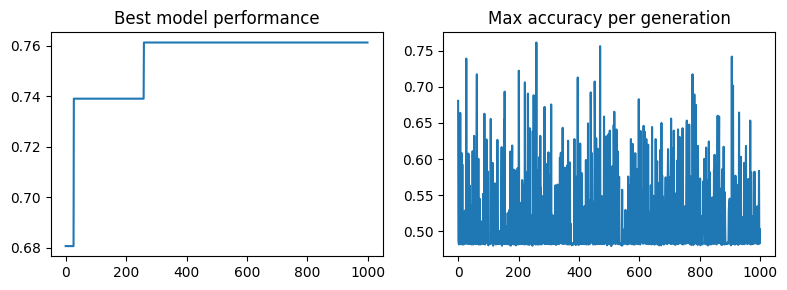

In [ ]:
# @title Merging with evolutionary algorithms (**You should spend some time here**)
# @markdown Questions to consider:
# @markdown   1. How is the number of elites `num_elite` going to affect the performance?
# @markdown   2. How important is the mutation operation?
# @markdown   3. How do we stablize the learning process?

# @markdown Feel free to play with the following:


n_iter = 1000  # @param
mutation_std = 0.01  # @param
pop_size = 512  # @param
num_elite = 8  # @param
seed = 42  # @param


def slerp(val, x, y):
    """Slerp merging."""
    # Normalize the inputs.
    norm_x = x / jnp.linalg.norm(x)
    norm_y = y / jnp.linalg.norm(y)

    # Cosine of the angle.
    dot = jnp.dot(norm_x, norm_y)
    omega = jnp.arccos(jnp.clip(dot, -1, 1))
    sin_omega = jnp.sin(omega)

    # Calculate scales for input vectors.
    scale_x = jnp.sin((1.0 - val) * omega) / sin_omega
    scale_y = jnp.sin(val * omega) / sin_omega

    # Linear interpolation weights.
    lin_scale_x = 1.0 - val
    lin_scale_y = val

    return jnp.where(sin_omega > 1e-6,
                    scale_x * x + scale_y * y,
                    lin_scale_x * x + lin_scale_y * y)


@jax.vmap
def crossover(parents, rand_key):
    w = jax.random.uniform(rand_key)
    return slerp(w, parents[0], parents[1])


@jax.vmap
def mutate(gene, rand_key):
    noise = jax.random.normal(rand_key, shape=gene.shape) * mutation_std
    return gene + noise


@jax.jit
def ask(elite_solutions, rand_key):
    rand_key, key1, key2, key3 = jax.random.split(rand_key, 4)
    ix = jax.random.choice(key1, num_elite, shape=(pop_size * 2,), replace=True)
    parents = jnp.take(elite_solutions, ix, axis=0)
    parents = parents.reshape([pop_size, 2, -1])
    keys = jax.random.split(key2, pop_size)
    population = crossover(parents, keys)
    keys = jax.random.split(key3, pop_size)
    population = mutate(population, keys)
    return population, rand_key


@jax.jit
def tell(elite_solutions, scores):
    scores, ix = jax.lax.top_k(scores, num_elite)
    new_elites = jnp.take(elite_solutions, ix, axis=0)
    new_elites = new_elites.at[-1].set(mlp1_param)
    new_elites = new_elites.at[-2].set(mlp2_param)
    return new_elites


def eval_params(params, x, y):
    logits = mlp(params, x)
    return get_acc(logits, y)

batch_eval = jax.jit(jax.vmap(eval_params, in_axes=(0, None, None)))


# Initialize the elites with seed models.
elites = jnp.concat(
    [mlp1_param[None, ...], mlp2_param[None, ...]], axis=0)
ix = jax.random.choice(
    jax.random.PRNGKey(seed=seed), 2, shape=(num_elite,),
)
elites = jnp.take(elites, ix, axis=0)


# Optimization loop.
key = jax.random.PRNGKey(seed=seed)
acc_max = []
for i in tqdm(range(n_iter)):
    population, key = ask(elites, key)
    scores = batch_eval(population, images, labels)
    elites = tell(elites, scores)
    acc_max.append(scores.max())


# Plot the results.
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(np.maximum.accumulate(acc_max))
ax.set_title('Best model performance')
ax = axes[1]
ax.plot(acc_max)
ax.set_title('Max accuracy per generation')

plt.tight_layout()

### Key Takeaways

* The number of elites (`num_elite`) in EA strongly influences the algorithm's performance, impacting convergence speed, genetic diversity, and solution quality.
* The mutation operation in EA is crucial for maintaining genetic diversity within the population. While crossover combines and recombines genetic material from parent solutions to explore new solution spaces, mutation introduces random alterations that can generate entirely new traits not present in the current population.

# Part 3. QD for Model Merging

While quality diversity (QD) is an advanced topic in EA, Part 2's task provides us a good opportunity to show how QD can stablize the learning process and help solve the model merging problem. Specifically, we will implement [MAP-Elites](https://arxiv.org/abs/1504.04909) in Part 3.

**About MAP-Elites**

The MAP-Elites algorithm is a distinctive method emphasizes exploring and illuminating the search space by identifying a diverse collection of high-performing solutions across various behavior characteristics dimensions (BCs). Instead of focusing solely on finding the optimal solution, MAP-Elites organizes the population into a multidimensional grid based on specific phenotypic traits, preserving the best individual within each grid cell. This structure promotes extensive exploration of the solution space across different BCs, fostering a comprehensive understanding of the possible trade-offs and synergies among those traits.

In [ ]:
# @title Define the BCs
# @markdown We will use the accuracies on digits 0-4 and 5-9 as our BCs.

print('Data information:')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

mask = labels < 5
d0to4_images, d0to4_labels = images[mask], labels[mask]
print(f'#d0to4_images={len(d0to4_images)}')

mask = labels >= 5
d5to9_images, d5to9_labels = images[mask], labels[mask]
print(f'#d5to9_images={len(d5to9_images)}')

Data information:
#samples=1797, image_size=(64,)
#odd_num_images=906
#even_num_images=891
#d0to4_images=901
#d5to9_images=896


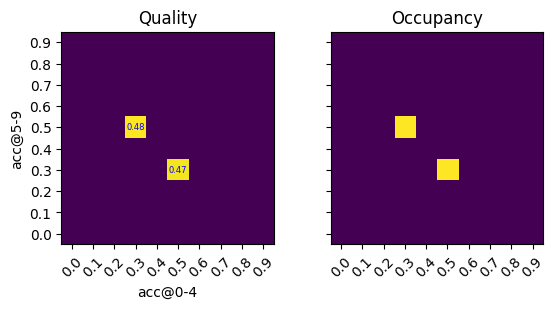

In [ ]:
# @title Initialize MAP-Elites states


# Description about archive.
#   dim0 is the accuracy on digits 0-4.
#   dim1 is the accuracy on digits 5-9,
#   each of which is bucketized into N grids each.
archive = jnp.zeros([10, 10, num_params])
qualities = jnp.zeros([10, 10])
occupied = jnp.zeros([10, 10], dtype=jnp.bool)


@jax.jit
def update_archive(param, archive, qualities, occupied):

    # Calculate BCs and Q.
    # Your code here

    # Update states.
    update_mask = # Your code here
    occupied = occupied.at[ix0, ix1].set(
        jax.lax.select(update_mask, True, occupied[ix0, ix1]))
    qualities = qualities.at[ix0, ix1].set(
        jax.lax.select(update_mask, q, qualities[ix0, ix1]))
    archive = archive.at[ix0, ix1].set(
        jax.lax.select(update_mask, param, archive[ix0, ix1]))

    return archive, qualities, occupied


def plot_archive(qualities, occupied):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    labels = [f'0.{x}' for x in range(10)]

    ax = axes[0]
    ax.imshow(qualities)
    ax.set_title('Quality')
    ax.set_xticks(ticks=np.arange(10), labels=labels, rotation=45)
    ax.set_yticks(ticks=np.arange(10), labels=labels)
    ax.set_xlabel('acc@0-4')
    ax.set_ylabel('acc@5-9')
    # Add score to the plot.
    for i in range(10):
        for j in range(10):
            if qualities[i, j] > 0:
                val = qualities[i, j]
                color = 'blue' if val > 0.4 else 'white'
                ax.text(j, i, f'{val:.2f}',
                        ha='center', va='center', fontsize=6, color=color)
    ax.invert_yaxis()

    ax = axes[1]
    ax.imshow(occupied)
    ax.set_title('Occupancy')
    ax.set_xticks(
        ticks=np.arange(10), labels=labels, rotation=45)
    ax.invert_yaxis()

    plt.tight_layout()


# Put the 2 MLPs into the archive.
for mlp_param in [mlp1_param, mlp2_param]:
    archive, qualities, occupied = update_archive(
        mlp_param, archive, qualities, occupied)
plot_archive(qualities, occupied)

In [ ]:
# @title Run MAP-Elites (**You should spend some time here**)


num_iter = 5000  # @param
seed = 42  # @param
mutation_std = 0.01  # @param


def sample_parents(archive, occupied, qualities, rand_key):
    # Your code here


@jax.jit
def qd_crossover(parents, rand_key):
    # Your code here


@jax.jit
def qd_mutate(gene, rand_key):
    # Your code here



quality_hist = []
occupancy_hist = []

key = jax.random.PRNGKey(seed)
for i in tqdm(range(num_iter)):
    k1, k2, k3, key = jax.random.split(key, 4)
    parents = sample_parents(archive, occupied, qualities, k1)
    child = qd_crossover(parents, k2)
    child = qd_mutate(child, k3)
    archive, qualities, occupied = update_archive(
        child, archive, qualities, occupied)

    if (i < 100 and i % 20 == 0) or (i > 100 and (i + 1) % 1000 == 0):
        quality_hist.append(qualities.copy())
        occupancy_hist.append(occupied.copy())


best_ix = jnp.argmax(qualities)
best_gene = archive.reshape(100, -1)[best_ix]
for x, y, name in zip(test_x, test_y, test_name):
    logits = mlp(best_gene, x)
    acc = get_acc(logits, y)
    print(f'best_gene acc@{name}={acc:.2f}')

 17%|█▋        | 866/5000 [01:36<01:34, 43.55it/s]

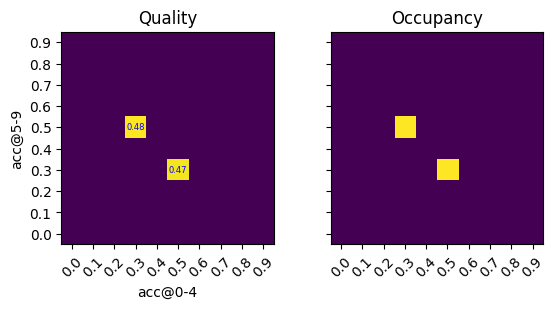

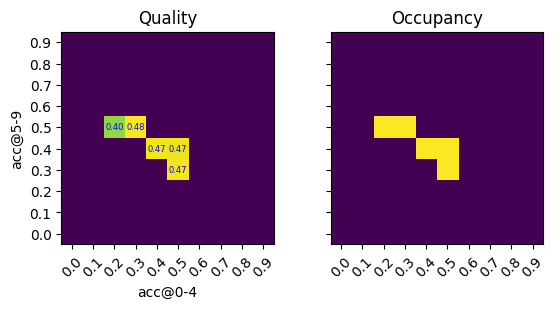

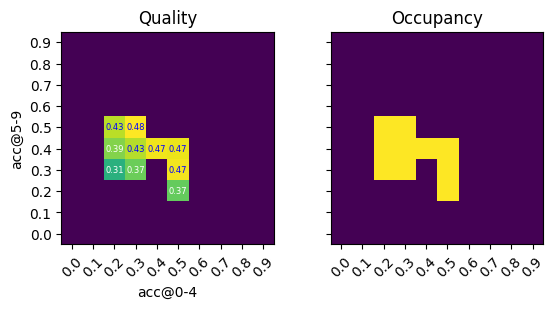

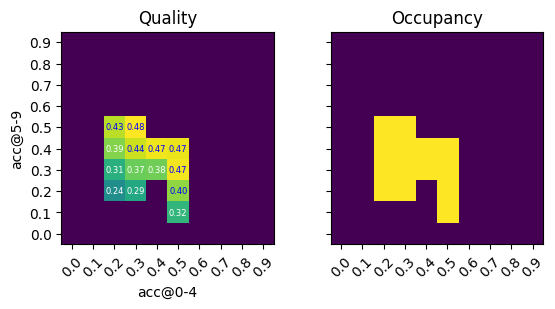

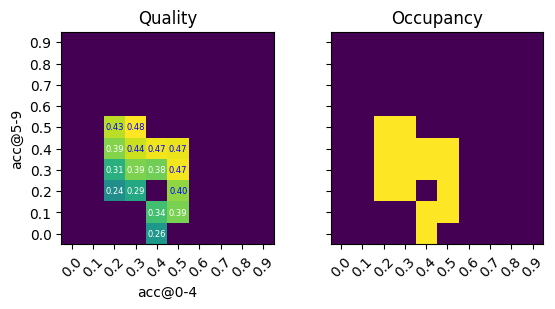

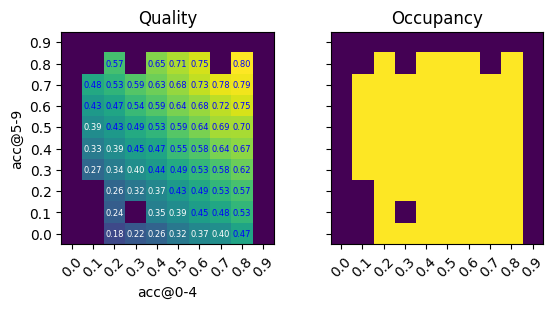

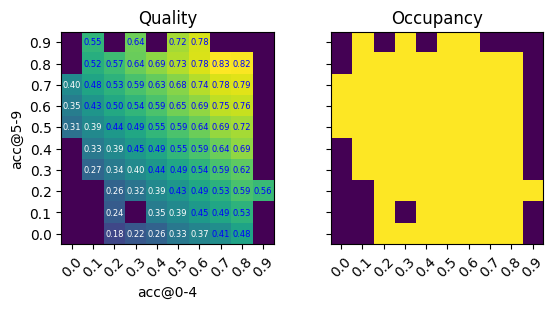

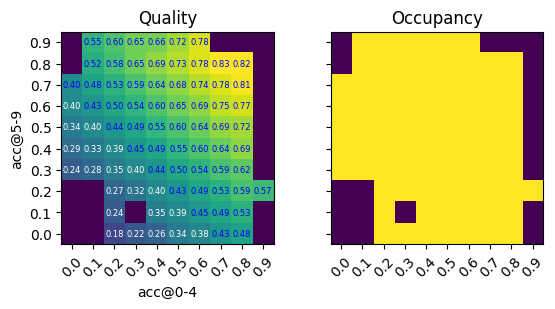

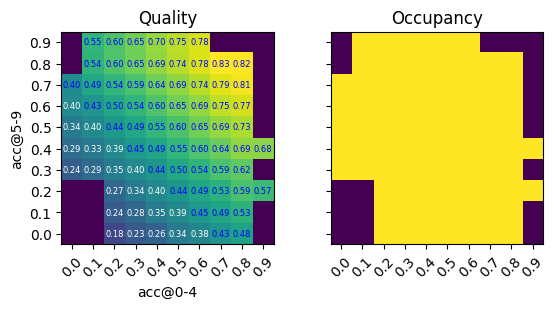

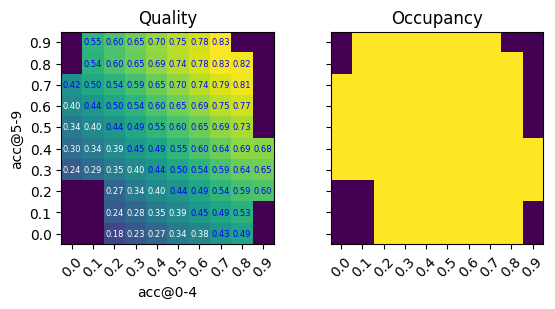

In [ ]:
# @title Visualize the evolution progress
# @markdown As the evolution progresses (scroll further down to view the figures), the archive becomes populated with a variety of solutions.

for q, o in zip(quality_hist, occupancy_hist):
    plot_archive(q, o)

### Key Takeaways

* Our simple MAP-Elites approach helps in maintaining a diverse set of neural network models that excel in different aspects of the MNIST digit recognition task.
* While the characters of different models in this exercise may seem trivial and somewhat contrived, MAP-Elites holds significant potential for tackling problems with more meaningful BCs. In such cases, the algorithm's ability to diversify becomes fundamentally crucial, providing robust and innovative solutions across a broader and more complex landscape. This diversification is particularly sound and advantageous in scenarios where nuanced exploration of the solution space is essential to uncovering optimal and creative strategies.